In [213]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

def cluster_data(clustering_data):
    wcsse = []
    silhouettes = []
    number_clusters = []
    for i in range(2, 10):
        kmeans = KMeans(i, n_init=45, algorithm='elkan')
        kmeans.fit(clustering_data)
        wcsse_iter = kmeans.inertia_
        silhouette = silhouette_score(clustering_data, kmeans.labels_)
        silhouettes.append(silhouette)
        wcsse.append(wcsse_iter)
        number_clusters.append(i)
    
    # Plot the wcsse and sillhoutte score
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    axs[0].set_title("wcsse")
    axs[0].plot(number_clusters, wcsse, '-o')
    axs[0].grid(True)
    axs[0].set_ylabel("Withing Cluster Sum of Squared Distances")

    axs[1].set_title("silhouette")
    axs[1].plot(number_clusters, silhouettes, '-o')
    axs[1].grid(True)
    axs[1].set_ylabel("Score")

    plt.show()

    return wcsse, silhouettes, number_clusters

def plot_three_bar_charts(data, columns, titles):
    # Create subplots for the bar charts
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define bar colors
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for i, (ax, col, title) in enumerate(zip(axes, columns, titles)):
        # Bar chart
        ax.bar(data['Cluster'], data[col], color=colors[i % len(colors)])
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Customer Segment', fontsize=12)
        # ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', linestyle='--')
        ax.tick_params(axis='x', labelrotation = 45)
        
        # Annotate each bar with its value
        for bar in ax.containers:
            ax.bar_label(bar, label_type='edge')

    plt.tight_layout()
    plt.show()


**Introduction**

This notebook aims to segment iFood customers based on their behavioral and demographic data to improve marketing campaign effectiveness. We will leverage clustering techniques to identify distinct customer groups, allowing for targeted marketing strategies.

**Research Questions:**

1.  How many distinct customer segments exist within the iFood customer base?
2.  What are the key characteristics of each customer segment (e.g., spending habits, campaign response, demographics)?
3.  Which segments are most likely to respond to specific marketing campaigns or channels?
4.  How can marketing resources be allocated more effectively across these identified customer segments to maximize ROI?

**RFM Segmentation Strategy**

For this initial segmentation, we will focus on the **Recency, Frequency, and Monetary (RFM) framework**. RFM is a widely used method for understanding customer behavior based on:

*   **Recency:** How recently a customer has made a purchase (number of days since last purchase).
*   **Frequency:** How often a customer makes purchases (number of total purchases).
*   **Monetary Value:** How much a customer spends over a given period (total spending amount).

RFM provides a powerful, behavior-based approach that directly reflects customer engagement and value. By analyzing these three factors, we can identify high-value customers, loyal customers, and those who might need re-engagement.

**Why Focus on RFM First?**

While factors like product preferences, channel usage, age, and education are valuable, they are secondary for our *initial* segmentation for several reasons:

*   **Behavioral Focus:** RFM directly reflects past actions, providing clear indicators of customer engagement and value. It allows us to quickly identify which customers are the most valuable from a revenue generation perspective.
*   **Actionable Insights:** RFM segments provide immediate and actionable insights for marketing strategies. For example, a segment of high-value, frequent purchasers can be targeted with exclusive offers to strengthen loyalty.
*   **Simplicity and Robustness:** RFM is straightforward to implement and is robust against noisy data. This is crucial when developing the initial model.
*   **Foundation for Further Analysis:**  RFM segmentation provides a solid foundation for more complex analysis. Once we have a clear picture of our customers based on RFM, we can then delve deeper into product preferences, channel behavior, and demographics.
*   **Marketing Focus:**  The primary goal of this project is to improve campaign effectiveness. RFM is specifically tailored to customer interaction patterns, which are highly relevant to marketing decisions.

In [214]:
df = pd.read_csv('ifood_dataset.csv').sort_index(axis=1)
df = df.drop_duplicates()

current_year = 2014

df['MntRegProds'] = (df['MntWines'] + df['MntMeatProducts'] + df['MntFruits'] + df['MntFishProducts'] + df['MntSweetProducts'] - df['MntGoldProds'])
df['TotalSpending'] = df[['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
df["NumTotalPurchases"] = df["NumCatalogPurchases"] + df["NumStorePurchases"] + df["NumWebPurchases"]
df["NumAcceptedCmp"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]
df["CustomerAge"] = current_year - df["Year_Birth"]
df["NumChildren"] = df["Kidhome"] + df["Teenhome"]

product_columns = ['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',]
df[product_columns] = df[product_columns].div(df['TotalSpending'], axis=0)

df[df["Marital_Status"] == "Alone"]["Marital_Status"] = "Single"
df[df["Marital_Status"] == "Married"]["Marital_Status"] = "Together"
df = df[(df["Marital_Status"] == "Single") | (df["Marital_Status"] == "Together") | (df["Marital_Status"] == "Widow")]

df.head()

/tmp/ipykernel_40636/1802094528.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_40636/1802094528.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Dt_Customer,Education,ID,Income,...,Teenhome,Year_Birth,Z_CostContact,Z_Revenue,MntRegProds,TotalSpending,NumTotalPurchases,NumAcceptedCmp,CustomerAge,NumChildren
0,0,0,0,0,0,0,2012-09-04,Graduation,5524,58138.0,...,0,1957,3,11,1441,1529,22,0,57,0
1,0,0,0,0,0,0,2014-03-08,Graduation,2174,46344.0,...,1,1954,3,11,15,21,4,0,60,2
2,0,0,0,0,0,0,2013-08-21,Graduation,4141,71613.0,...,0,1965,3,11,692,734,20,0,49,0
3,0,0,0,0,0,0,2014-02-10,Graduation,6182,26646.0,...,0,1984,3,11,43,48,6,0,30,1
5,0,0,0,0,0,0,2013-09-09,Master,7446,62513.0,...,1,1967,3,11,688,702,20,0,47,1


### RFM Distributions Below

*   **TotalSpending:** Left-skewed, higher spending concentrated.
*   **Recency:** Uniform.
*   **NumTotalPurchases:** Right-skewed, many with few purchases.

We'll apply a standard scaler to our three columns. We could also apply MinMax for Recency.

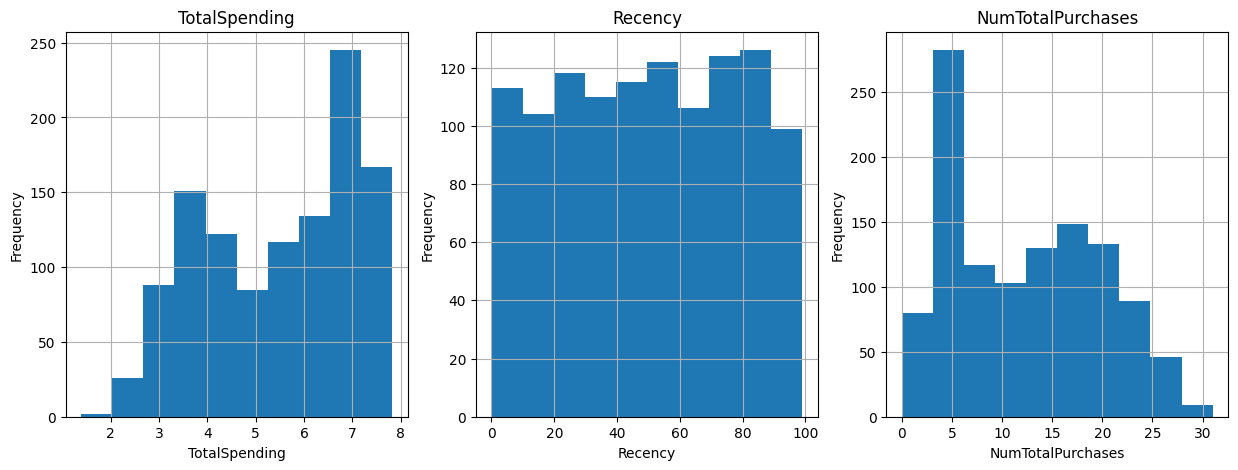

In [215]:
axes = plt.subplots(1, 3, figsize=(15, 5))[1]

for i, column in enumerate(['TotalSpending', 'Recency', 'NumTotalPurchases']):
    ax = axes[i]
    if i == 0:
        # apply log before plot hist
        df[column].apply(np.log).hist(ax=ax)
    else:
        df[column].hist(ax=ax)
    ax.set_title(column)
    ax.set_ylabel("Frequency")
    ax.set_xlabel(column)

### K-Means Clustering: Method & Rationale

**What is K-Means?**

*   Unsupervised algorithm for partitioning data into *k* clusters.
*   Iteratively assigns points to nearest centroid and updates centroids based on cluster means.
*   Aims to minimize the distance between data points and their cluster's centroid.

**Why Use K-Means for Segmentation?**

*   **Simple & Efficient:** Computationally fast, easy to implement and interpret.
*   **Unsupervised:** Discovers customer groups based on RFM similarities without pre-defined labels.
*   **Actionable Segments:** Provides clear customer segments for targeted marketing.
*   **Scalable:** Suitable for large datasets of customers.
*  **Foundation:** Provides a foundation for further analysis by enabling an understanding of the characteristics of the segments

**Limitations:**

*   Requires pre-defining the number of clusters (*k*), we will use the elbow method to find the optimal value.
*   Results can depend on the random initialization of centroids.
*   Assumes clusters have a spherical shape.

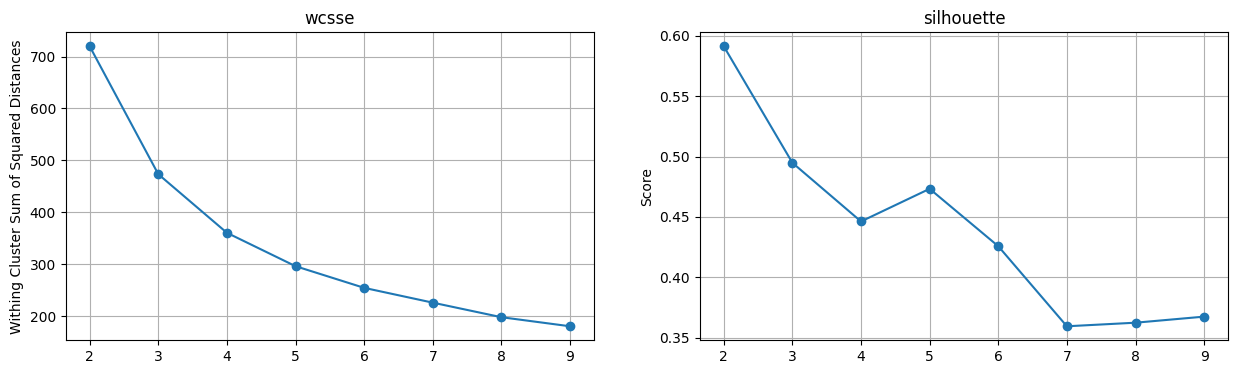

In [216]:
# Select the relevant columns
rfm_columns = ["TotalSpending", "Recency", "NumTotalPurchases", ]
full_data_scaled = df[rfm_columns].copy()

# Apply StandardScaler
full_data_scaled[rfm_columns] = StandardScaler().fit_transform(full_data_scaled)
full_data_scaled['Recency'] = MinMaxScaler().fit_transform(df[['Recency', ]])

wcsse, silhouettes, number_clusters = cluster_data(full_data_scaled)

### Determining the Optimal Number of Clusters (k)

To determine the optimal number of clusters (*k*) for our k-means algorithm, we analyzed two common metrics:

1.  **Within-Cluster Sum of Squared Errors (WCSS) - Elbow Method:**

    *   The WCSS measures the sum of squared distances between each point and its cluster's centroid. Lower WCSS values generally indicate tighter, more cohesive clusters.
    *   The plot shows that WCSS decreases as *k* increases, as expected.
    *   We look for an "elbow" point, where the rate of decrease in WCSS slows down, indicating that adding more clusters provides diminishing returns.
    *   In our plot, the most prominent elbow appears to be around **k=4**, after this point, the reduction in WCSS diminishes.

2.  **Silhouette Score:**

    *   The Silhouette score measures how similar an object is to its own cluster compared to other clusters. Scores range from -1 to 1, with higher scores indicating better-defined clusters.
    *   The plot shows the Silhouette scores for each tested number of clusters.
    *   In our plot, we see the highest score occurs at **k=5**, with a small increase from k=4 to k=5, suggesting a better separation between clusters at that point.
    *  The drop after k=5 indicates that increasing the number of clusters will result in overlapping clusters.

**Rationale for Choosing k=5:**

Considering both plots, **we choose k=5 as the optimal number of clusters for the following reasons:**

*   **Elbow Point:** The WCSS plot shows a prominent "elbow" around *k*=4, but we will go a step further to better adjust to silhouette score.
*   **Silhouette Score Peak:** The silhouette score peaks at *k*=5, indicating that this number of clusters provides a higher level of separation and better-defined clusters in our data than the 4-cluster solution.
*   **Interpretability:** While one more cluster might add complexity, five clusters still provide a manageable number of segments with distinct characteristics, allowing for refined marketing strategies.
*   **Business Value:** We believe that having five distinct segments will allow us to design differentiated marketing strategies that can better target each group based on the characteristics of each cluster.

Therefore, based on the analysis of WCSS and Silhouette scores, a 5-cluster solution provides a good balance between model quality, interpretability, and business relevance.

In [217]:
model = KMeans(n_clusters=5, max_iter=200, n_init=45, random_state=0)

new_full_data = df.copy()
new_full_data['Cluster'] = model.fit_predict(full_data_scaled)

In [218]:
fig = px.scatter_3d(data_frame=new_full_data, x="NumTotalPurchases", 
                    y="TotalSpending", z="Recency", color="Cluster", height=550,
                title = "Visualizing Cluster Result Using 3 Features")
fig.show()

### Customer Segment Descriptions Based on RFM Averages

Based on the average `TotalSpending` and `NumTotalPurchases` values, we can categorize our k-means clusters into four distinct customer segments:

**Segment Descriptions:**

1.  **Very Low-Spending:**
    *   This segment has the lowest average `TotalSpending`, the lowest `NumTotalPurchases`, and the lowest `Response` rate (around 9%).
    *   They make very infrequent purchases and are least likely to respond to campaigns.

2.  **Low-Spending:**
    *   This segment has a low average `TotalSpending`, a mid-range average `NumTotalPurchases`, and a low `Response` rate (about 12%).
    *   They are occasional purchasers and do not respond much to campaigns.

3.  **Mid-Spending:**
    *   This segment has a mid-range average `TotalSpending`, a high average `NumTotalPurchases`, and a `Response` rate around 13%.
    *    These customers purchase more often, with a moderate average spending and response rate.

4.  **High-Spending:**
    *   This segment has a high average `TotalSpending`, a mid-range `NumTotalPurchases`, and a better `Response` rate (around 20%).
    * These customers are frequent purchasers, high spending and with a better response rate compared with the previous segments.

5.  **Very High-Spending:**
    *   This segment has the highest average `TotalSpending`, high `NumTotalPurchases`, and the highest `Response` rate (almost 40%).
    *   They are our most loyal, high-spending customers who are highly responsive to campaigns.

In [219]:
cluster_mean_values = new_full_data.groupby(by='Cluster').agg({'Response': 'mean', 'NumTotalPurchases': 'mean', 'TotalSpending': 'mean', 'Recency': 'mean'}).reset_index().sort_values(by='TotalSpending')
mapping = {
    cluster_mean_values.index[0]: '0 - Very Low-Spending',
    cluster_mean_values.index[1]: '1 - Low-Spending',
    cluster_mean_values.index[2]: '2 - Mid-Spending',
    cluster_mean_values.index[3]: '3 - High-Spending',
    cluster_mean_values.index[4]: '4 - Very High-Spending',
}
# cluster_mean_values.index[3]
new_full_data['Cluster'].replace(mapping, inplace=True)
cluster_mean_values['Cluster'].replace(mapping, inplace=True)
cluster_mean_values

,Cluster,Response,NumTotalPurchases,TotalSpending,Recency
1,0 - Very Low-Spending,0.096436,5.274633,61.842767,50.668763
3,1 - Low-Spending,0.130252,13.743697,406.819328,46.978992
2,2 - Mid-Spending,0.143791,22.797386,890.137255,45.921569
4,3 - High-Spending,0.222222,15.531746,1152.682540,53.873016
0,4 - Very High-Spending,0.405594,20.517483,1698.020979,52.062937


### Current Campaign Response Distribution by Customer Segment

This chart shows campaign response rates across our five customer segments, highlighting the varying effectiveness of our marketing efforts.

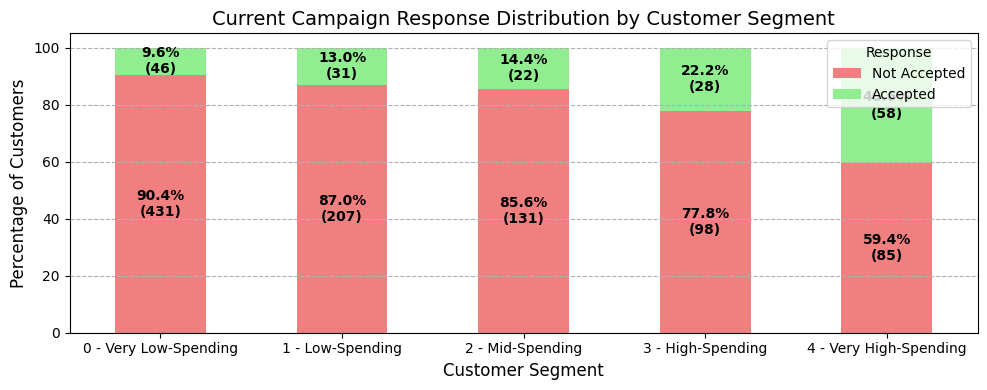

In [220]:
# Calculate response percentages per cluster
response_by_cluster = new_full_data.groupby(['Cluster', 'Response']).size().unstack(fill_value=0)
response_by_cluster_pct = response_by_cluster.div(response_by_cluster.sum(axis=1), axis=0) * 100

# Create the clustered bar chart
fig, ax = plt.subplots(figsize=(10, 4))

response_by_cluster_pct.plot(kind='bar', stacked=True, ax=ax, color = ['lightcoral', 'lightgreen'])

# Customize the chart
plt.title('Current Campaign Response Distribution by Customer Segment', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Percentage of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Response', labels=['Not Accepted', 'Accepted'])
plt.grid(axis='y', linestyle='--')

counter = [x for xs in response_by_cluster.T.sort_index().values for x in xs ]

# Add percentages to the bar
for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2,
            y + height/2,
            f'{height:.1f}%\n({counter[i]})',
            ha='center',
            va='center',
             color='black', weight='bold')

plt.tight_layout()
plt.show()

We can see that there is a positive correlation between the amount spent with the percentage of customers accepting the last campaign in each cluster. In special, we see that the biggest amount of customers accepting campaign comes from the very high-spending cluster.

In [197]:
# Aggregate data by cluster
aggregated_data = new_full_data.groupby('Cluster').agg(
    avg_income = pd.NamedAgg(column='Income', aggfunc='mean'),
    avg_spending = pd.NamedAgg(column='TotalSpending', aggfunc='mean'),
    avg_children = pd.NamedAgg(column='NumChildren', aggfunc='mean'),
    avg_store_purchases = pd.NamedAgg(column='NumStorePurchases', aggfunc='mean'),
    avg_web_purchases = pd.NamedAgg(column='NumWebPurchases', aggfunc='mean'),
    avg_catalog_purchases = pd.NamedAgg(column='NumCatalogPurchases', aggfunc='mean'),

    avg_kids = pd.NamedAgg(column='Kidhome', aggfunc='mean'),
    avg_teen = pd.NamedAgg(column='Teenhome', aggfunc='mean'),

    avg_mnt_meat_mean = pd.NamedAgg(column='MntMeatProducts', aggfunc='mean'),
    avg_mnt_fish_mean = pd.NamedAgg(column='MntFishProducts', aggfunc='mean'),
    avg_mnt_fruits_mean = pd.NamedAgg(column='MntFruits', aggfunc='mean'),
    avg_mnt_wine_mean = pd.NamedAgg(column='MntWines', aggfunc='mean'),
    avg_mnt_gold_mean = pd.NamedAgg(column='MntGoldProds', aggfunc='mean'),
    avg_mnt_sweet_mean = pd.NamedAgg(column='MntSweetProducts', aggfunc='mean'),

    avg_num_cmps = pd.NamedAgg(column='NumAcceptedCmp', aggfunc='mean'),
    avg_recency = pd.NamedAgg(column='Recency', aggfunc='mean'),
    
    avg_web_visits = pd.NamedAgg(column='NumWebVisitsMonth', aggfunc='mean'),
    avg_deals = pd.NamedAgg(column='NumDealsPurchases', aggfunc='mean'),
    avg_purchases = pd.NamedAgg(column='NumTotalPurchases', aggfunc='mean'),
).reset_index()

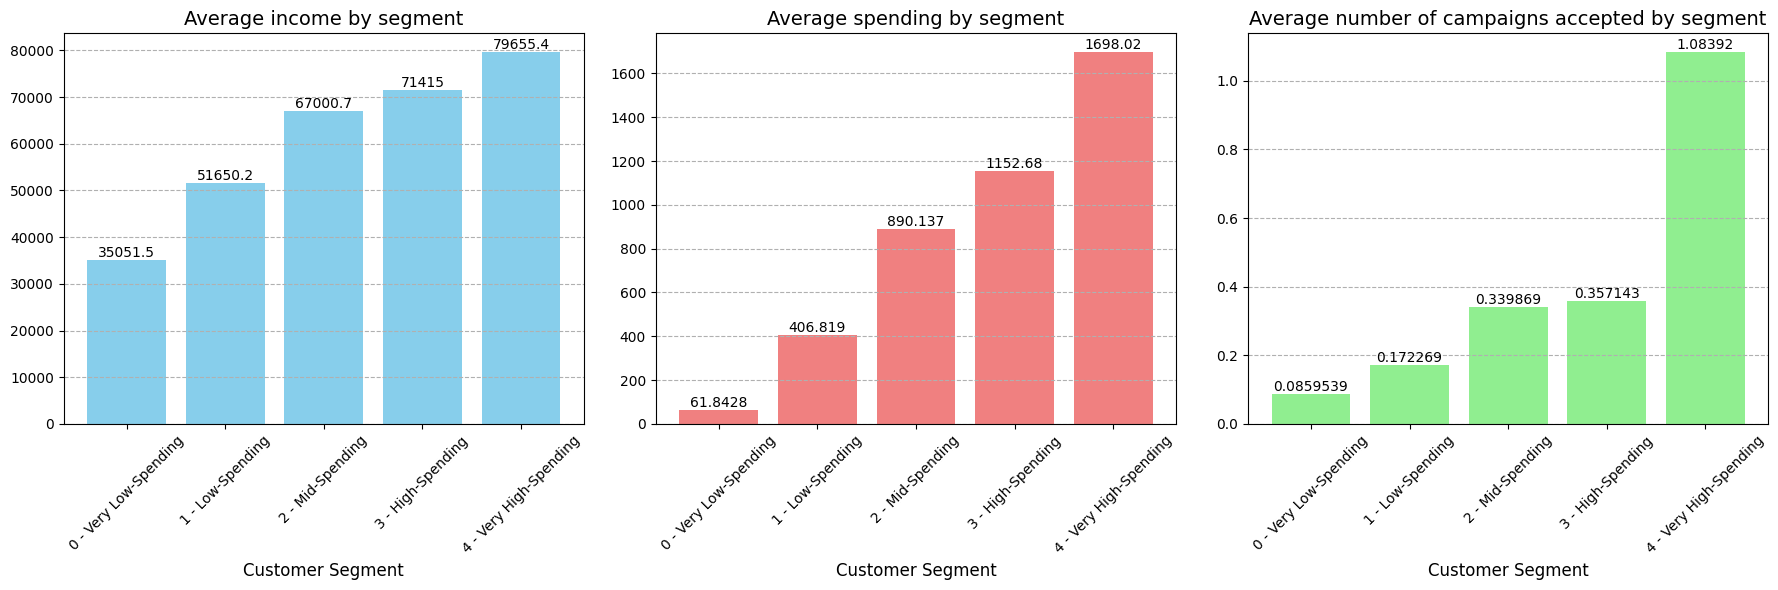

In [190]:

plot_three_bar_charts(
    aggregated_data,
    ['avg_income', 'avg_spending', 'avg_num_cmps'],
    ['Average income by segment', 'Average spending by segment', 'Average number of campaigns accepted by segment']
)


From the above plot, we see that there is a strong positive correlation between income, total spend, and amount of accepted campaigns.

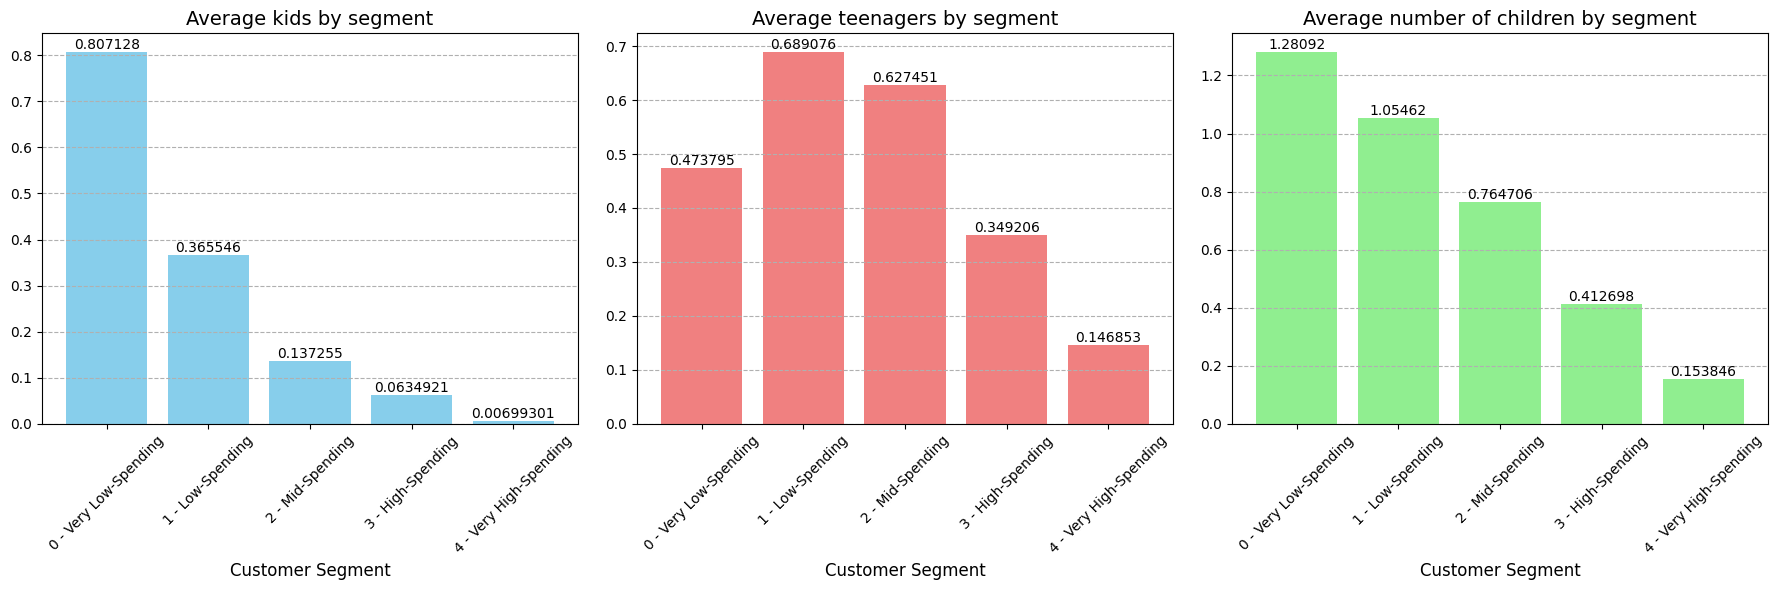

In [191]:
plot_three_bar_charts(
    aggregated_data,
    ['avg_kids', 'avg_teen', 'avg_children'],
    ['Average kids by segment', 'Average teenagers by segment', 'Average number of children by segment']
)

*   The "Very Low-Spending" segment has the highest average number of kids, but very few teenagers, which contrasts the other segments.
*   The "Mid-Spending" and "High-Spending" segments have the highest average number of teenagers.
*   The "Very High-Spending" almost have no children.


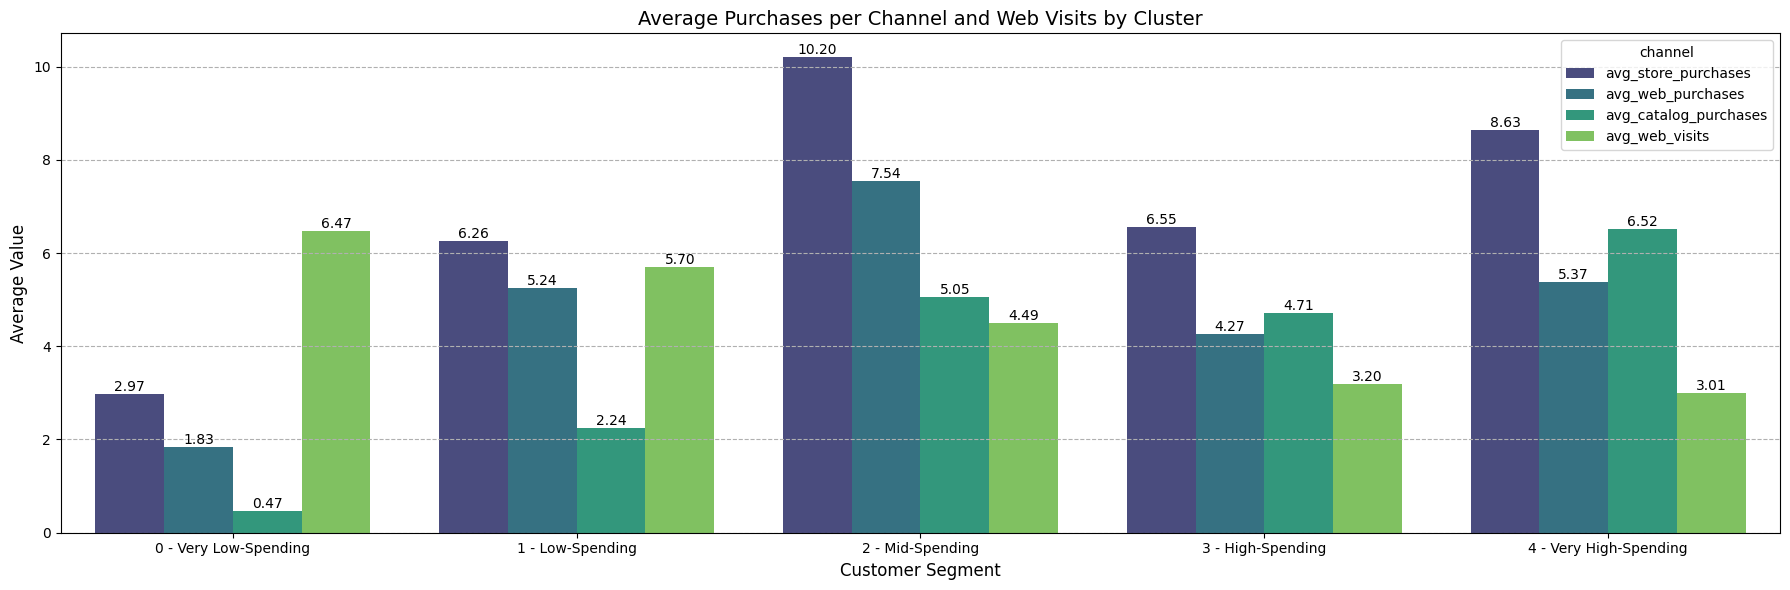

In [226]:
# Create subplots for the bar charts
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

# Melt the dataframe for channel purchases
df_melted = aggregated_data.melt(
    id_vars = ['Cluster'],
    value_vars = ['avg_store_purchases', 'avg_web_purchases', 'avg_catalog_purchases', 'avg_web_visits'],
    var_name = 'channel',
    value_name = 'avg_value'
)

# Bar Chart 3: Average Purchases per channel and web visits by Cluster
sns.barplot(data = df_melted, x='Cluster', y='avg_value', hue='channel', ax = axes, palette='viridis')
axes.set_title('Average Purchases per Channel and Web Visits by Cluster', fontsize=14)
axes.set_xlabel('Customer Segment', fontsize=12)
axes.set_ylabel('Average Value', fontsize=12)
axes.grid(axis='y', linestyle='--')
# axes[2].legend(title='Channels', labels=['Store Purchases', 'Web Purchases', 'Catalog Purchases', 'Web Visits'])

for bar in axes.containers:
    axes.bar_label(bar, fmt='%.2f')

plt.tight_layout()
plt.show()

- Very Low Spend prefer stores and web purchases. They have the highest amount of web visits.
- Low spending and mid spending customers also prefer stores and web channel.
- High-spending and Very-high spending customers prefer store and catalog purchases. They are the ones having the smallest amount of web visits.

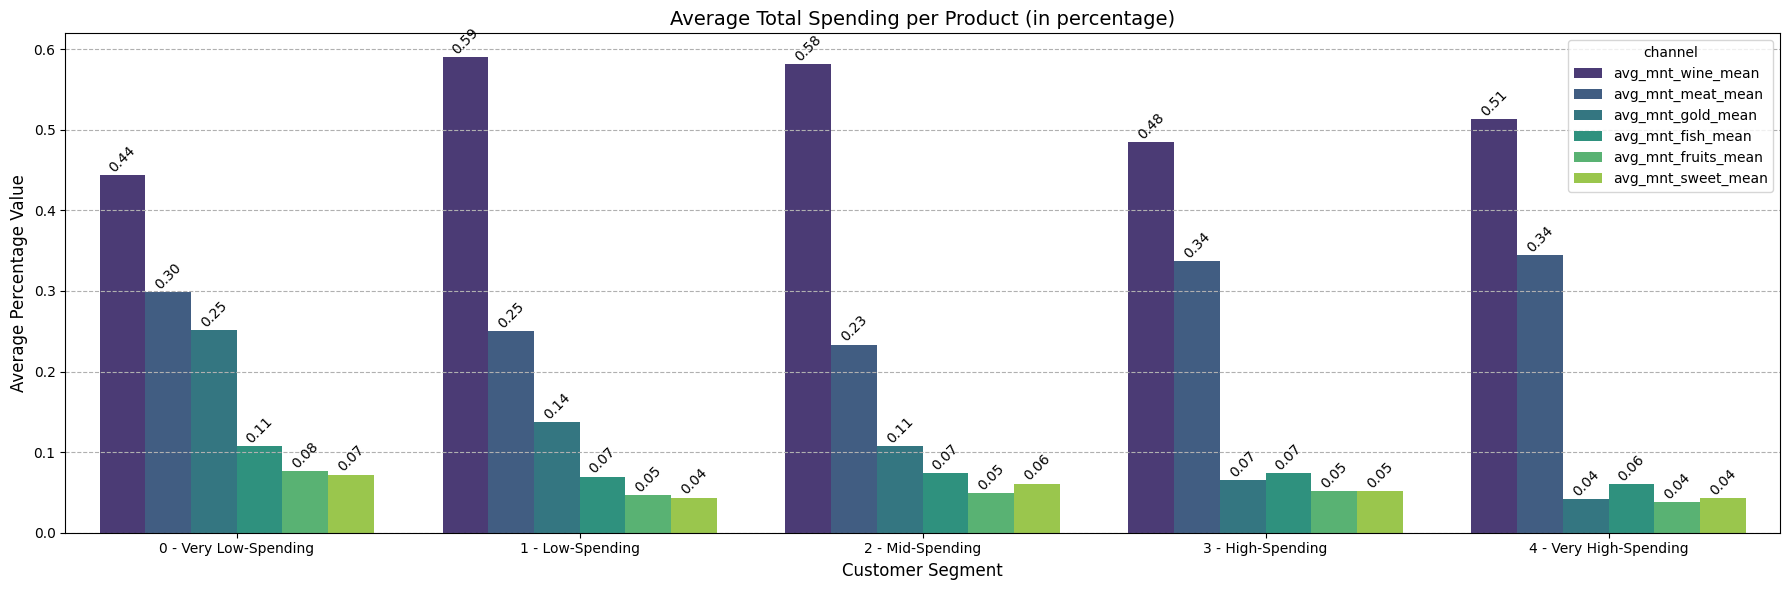

In [227]:
# Create subplots for the bar charts
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

df_melted_mnt_prods = aggregated_data.melt(
    id_vars = ['Cluster'],
    value_vars = ['avg_mnt_wine_mean', 'avg_mnt_meat_mean', 'avg_mnt_gold_mean', 'avg_mnt_fish_mean', 'avg_mnt_fruits_mean',  'avg_mnt_sweet_mean', ],
    var_name = 'channel',
    value_name = 'avg_mnt'
)

# Bar Chart 3: Average Purchases per channel and web visits by Cluster
sns.barplot(data = df_melted_mnt_prods, x='Cluster', y='avg_mnt', hue='channel', ax = axes, palette='viridis')
axes.set_title('Average Total Spending per Product (in percentage)', fontsize=14)
axes.set_xlabel('Customer Segment', fontsize=12)
axes.set_ylabel('Average Percentage Value', fontsize=12)
axes.grid(axis='y', linestyle='--')
# axes[2].legend(title='Channels', labels=['Store Purchases', 'Web Purchases', 'Catalog Purchases', 'Web Visits'])

for bar in axes.containers:
    axes.bar_label(bar, fmt='%.2f', label_type='edge', rotation=45)

plt.tight_layout()
plt.show()

* Very low spenders consume 44% on wine and 30% on meat. From those, 25% are gold products.
* Low spenders consume 59% on wine and 25% on meat. Only 14% on gold products.
* Mid-spenders consume 58% on wine, 23% on meat. 11% on gold products.
* High spenders consume 48% on wine, 34% on meat. 7% on gold.
* Very high spenders consume 51% on wine, 34% on meat. 4% on gold products.

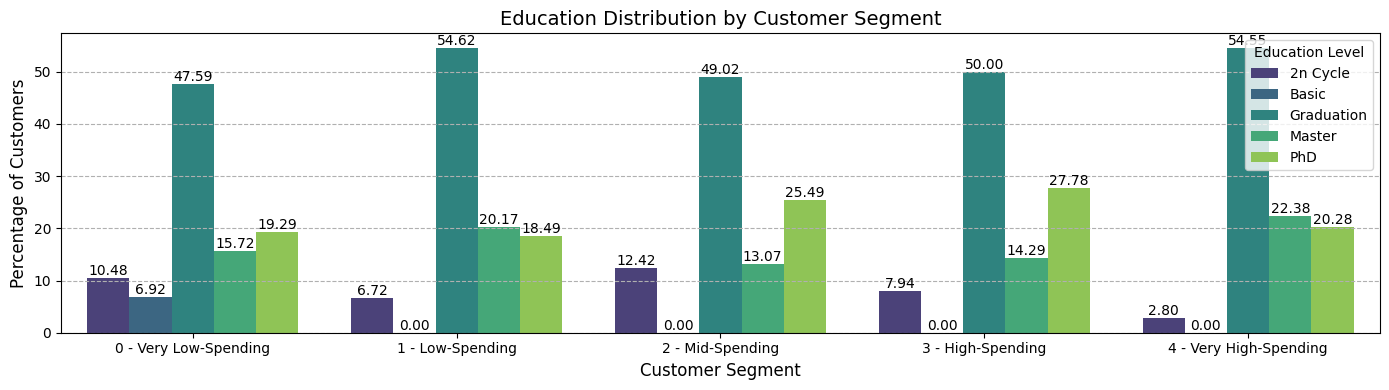

In [194]:
# Calculate education percentages per cluster
education_by_cluster = new_full_data.groupby(['Cluster', 'Education']).size().unstack(fill_value=0)
education_by_cluster_pct = education_by_cluster.div(education_by_cluster.sum(axis=1), axis=0) * 100

# Melt the data
df_melted_education = education_by_cluster_pct.reset_index().melt(
    id_vars = ['Cluster'],
    var_name = 'education',
    value_name = 'percentage'
)

# Create the grouped bar chart
plt.figure(figsize=(14, 4))
bars = sns.barplot(data = df_melted_education, x='Cluster', y='percentage', hue = 'education', palette = 'viridis')

plt.title('Education Distribution by Customer Segment', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Percentage of Customers', fontsize=12)
plt.legend(title='Education Level')
plt.grid(axis='y', linestyle='--')

# Annotate each bar with its percentage
for bar in bars.containers:
    bars.bar_label(bar, fmt='%.2f')

plt.tight_layout()
plt.show()

* Majority of consumers in each cluster have a graduation.
* Mid and high spenders are the ones with the highest percentage of PhDs.

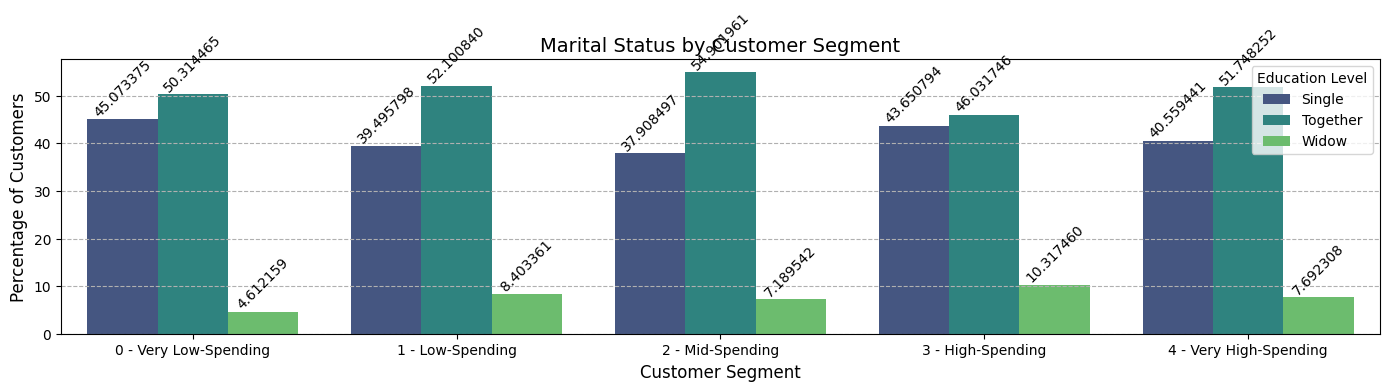

In [195]:
# Calculate education percentages per cluster
marital_by_cluster = new_full_data.groupby(['Cluster', 'Marital_Status']).size().unstack(fill_value=0)
marital_by_cluster_pct = marital_by_cluster.div(marital_by_cluster.sum(axis=1), axis=0) * 100

# Melt the data
df_melted_marital = marital_by_cluster_pct.reset_index().melt(
    id_vars = ['Cluster'],
    var_name = 'marital',
    value_name = 'percentage'
)

# Create the grouped bar chart
plt.figure(figsize=(14, 4))
bars = sns.barplot(data = df_melted_marital, x='Cluster', y='percentage', hue = 'marital', palette = 'viridis')

plt.title('Marital Status by Customer Segment', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Percentage of Customers', fontsize=12)
plt.legend(title='Education Level')
plt.grid(axis='y', linestyle='--')

# Annotate each bar with its percentage
for bar in bars.containers:
    bars.bar_label(bar, fmt='%2f', rotation=45)

plt.tight_layout()
plt.show()

* Majority of customers are married, although it's close to the amount of single people. In the very high spending, majority is married.

### Customer Segment Preferences: A Concise Summary

**1. Very High-Spending Segment:**
-  **Spending:** Highest average spending.
-  **Response:** Highly responsive to campaigns.
-  **Channels:** Prefers store and catalog purchases. Low website visits.
-  **Products:** High preference for wine and meat.
-  **Family:** More couples than single. Almost no child.
- **Education:** Well distributed among "Graduation", "Master" and "PhD"

**2. High-Spending Segment:**
-   **Spending:** High average spending.
-   **Response:** Above-average response rate to campaigns.
-   **Channels:** Prefers store and catalog purchases.
-  **Products:** High preference for wine and meat.
-   **Family:** High number of teenagers in the household.
- **Education:** Majority "Graduation"

**3. Mid-Spending Segment:**
-   **Spending:** Mid-range average spending.
-   **Response:** Low response rate to campaigns.
-   **Channels:** Prefers store and web purchases.
-   **Products:** High preference for wine and meat.
-   **Family:** High number of teenagers in the household.
-   **Education:** Majority "Graduation"

**4. Low-Spending Segment:**
-   **Spending:** Low average spending.
-   **Response:** Low response rate to campaigns.
-   **Channels:** Prefers stores and web purchases.
-   **Products:**  High preference for wine and meat.
-   **Family:** High proportion of teenagers.
-  **Education:** Majority "Graduation"

**5. Very Low-Spending Segment:**
-   **Spending:** Very low average spending.
-   **Response:** Very low response rate to campaigns.
-   **Channels:** Prefers stores and web purchases. High web site visits.
-   **Products:** High preference for wine and meat. Spend a lot on gold products.
-  **Family:** Has the highest number of kids, with very some teenagers.
-   **Education:** Majority "Graduation"

**Overall Summary:**

*   **Spending Drives Engagement:** Higher spending segments consistently show greater campaign responsiveness.
*   **Channel Preferences Vary:** While store purchases are important, catalog purchases are more popular with mid to high-spending customers.
*   **Wine & Meat Products** These are preferred by high spending segments.